In [52]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from itertools import product
from transformers import BertTokenizer, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from projAll import filtered_labels_at_least_5_list, CustomBertModel, create_dataset, train_with_validation, test, combined_df

In [53]:
param_grid = {
    'learning_rate': [5e-5, 3e-5, 1e-5],
    'batch_size': [16, 32],
    'num_epochs': [4, 6]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_mapping = {label: idx for idx, label in enumerate(filtered_labels_at_least_5_list)}

In [54]:
# df = pd.read_csv('csv/merged_aug.csv')
df = combined_df

In [55]:
train_val_df, test_df = train_test_split(df,
                                         test_size=0.2,
                                         stratify=df['Artifact Id'],
                                         random_state=42)
train_df, val_df = train_test_split(train_val_df,
                                         test_size=0.2,
                                         stratify=train_val_df['Artifact Id'],
                                         random_state=42)

In [56]:
def plot(acc_train, acc_val, acc_test, f1_train, f1_val, f1_test, params):
    num_epochs = params['num_epochs']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    
    epochs = range(1, num_epochs + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

    # Plot Accuracy
    axes[0].plot(epochs, acc_train, color='blue', linestyle='-', label='Train Accuracy')
    axes[0].plot(epochs, acc_val, color='red', linestyle='-', label='Validation Accuracy')
    axes[0].set_title('Accuracy Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].legend()
    axes[0].grid(True)

    # Plot F1 Score
    axes[1].plot(epochs, f1_train, color='blue', linestyle='-', label='Train F1 Score')
    axes[1].plot(epochs, f1_val, color='red', linestyle='-', label='Validation F1 Score')
    axes[1].set_title('F1 Score Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')
    axes[1].legend()
    axes[1].grid(True)

    test_results_text = f"Test Accuracy: {acc_test:.2f}%\nTest F1 Score: {f1_test:.4f}"
    props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='black')
    fig.text(0.5, -0.05, test_results_text, fontsize=10, bbox=props, ha='center')

    fig.suptitle(f"Training, Validation, and Test Metrics\n"
                 f"Epochs: {num_epochs}, Learning Rate: {learning_rate}, Batch Size: {batch_size}", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle
    plt.show()

Training with params: {'learning_rate': 5e-05, 'batch_size': 16, 'num_epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch 1/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.284567, Accuracy: 14.285714%, F1 Score: 0.080998
Validation Accuracy: 18.750000%, Validation F1 Score: 0.118750


Training Epoch 2/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.119917, Accuracy: 19.047619%, F1 Score: 0.165505
Validation Accuracy: 18.750000%, Validation F1 Score: 0.123162


Training Epoch 3/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 1.956706, Accuracy: 36.507937%, F1 Score: 0.298491
Validation Accuracy: 43.750000%, Validation F1 Score: 0.321429


Training Epoch 4/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 1.809750, Accuracy: 60.317460%, F1 Score: 0.513379
Validation Accuracy: 37.500000%, Validation F1 Score: 0.273214


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

F1 Score (Weighted): 0.3536
Accuracy: 45.00%


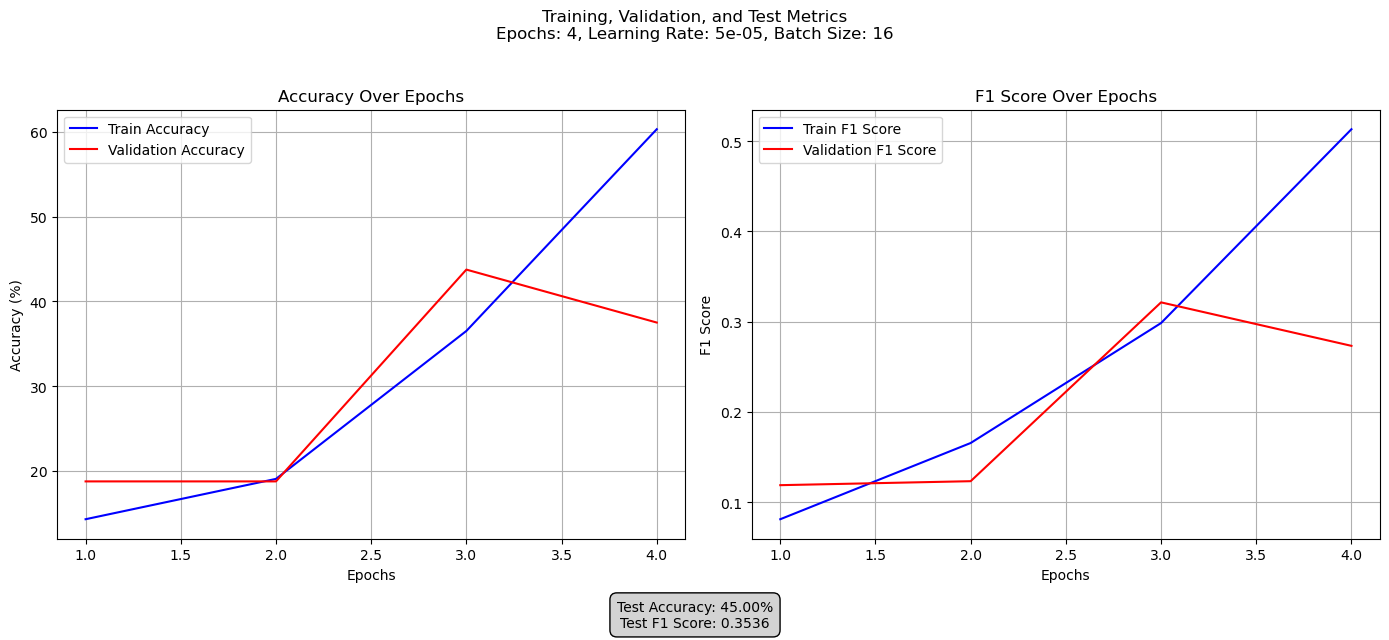

Training with params: {'learning_rate': 5e-05, 'batch_size': 16, 'num_epochs': 6}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.154643, Accuracy: 15.873016%, F1 Score: 0.107181
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.142038, Accuracy: 22.222222%, F1 Score: 0.147135
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 3/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.098085, Accuracy: 28.571429%, F1 Score: 0.232171
Validation Accuracy: 25.000000%, Validation F1 Score: 0.173214


Training Epoch 4/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.002508, Accuracy: 28.571429%, F1 Score: 0.251935
Validation Accuracy: 43.750000%, Validation F1 Score: 0.324405


Training Epoch 5/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 1.908680, Accuracy: 52.380952%, F1 Score: 0.410237
Validation Accuracy: 37.500000%, Validation F1 Score: 0.255357


Training Epoch 6/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 1.726676, Accuracy: 52.380952%, F1 Score: 0.416953
Validation Accuracy: 50.000000%, Validation F1 Score: 0.389881


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

F1 Score (Weighted): 0.4625
Accuracy: 60.00%


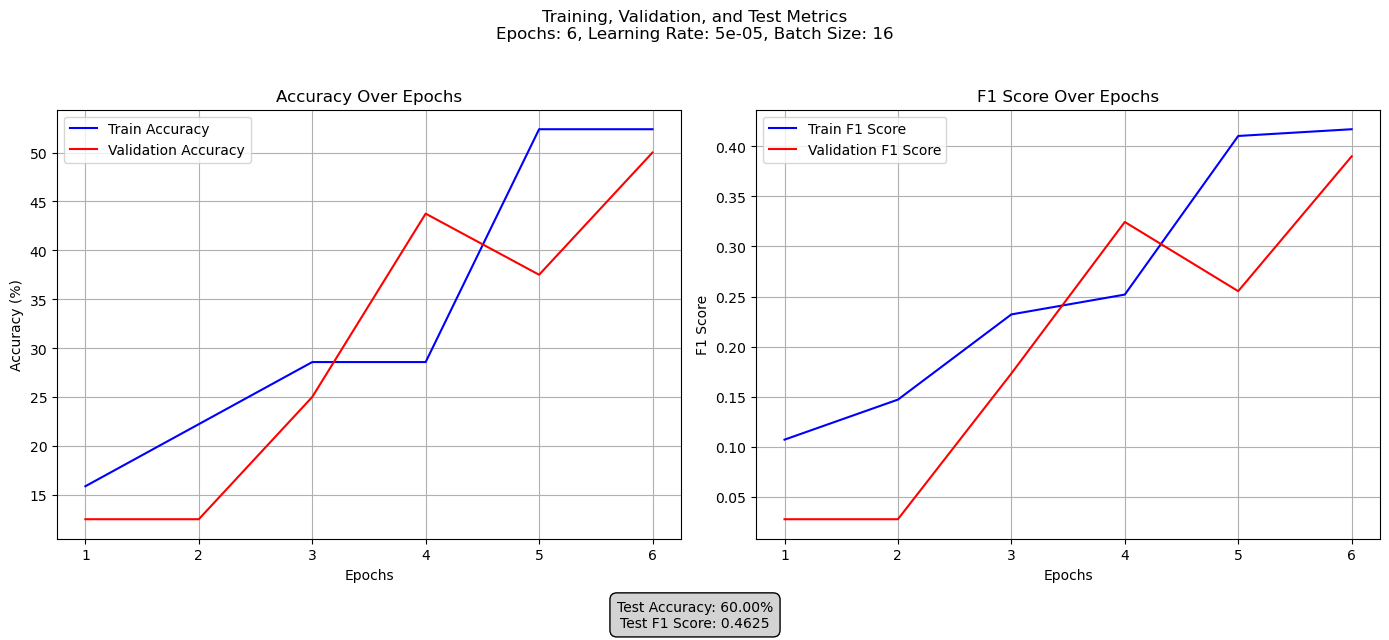

Training with params: {'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 1/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.250656, Accuracy: 11.111111%, F1 Score: 0.050770
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 2/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.126743, Accuracy: 14.285714%, F1 Score: 0.090602
Validation Accuracy: 18.750000%, Validation F1 Score: 0.081169


Training Epoch 3/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 3/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.037633, Accuracy: 28.571429%, F1 Score: 0.193754
Validation Accuracy: 25.000000%, Validation F1 Score: 0.216477


Training Epoch 4/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 4/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 1.958298, Accuracy: 34.920635%, F1 Score: 0.283137
Validation Accuracy: 43.750000%, Validation F1 Score: 0.319196


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

F1 Score (Weighted): 0.4111
Accuracy: 50.00%


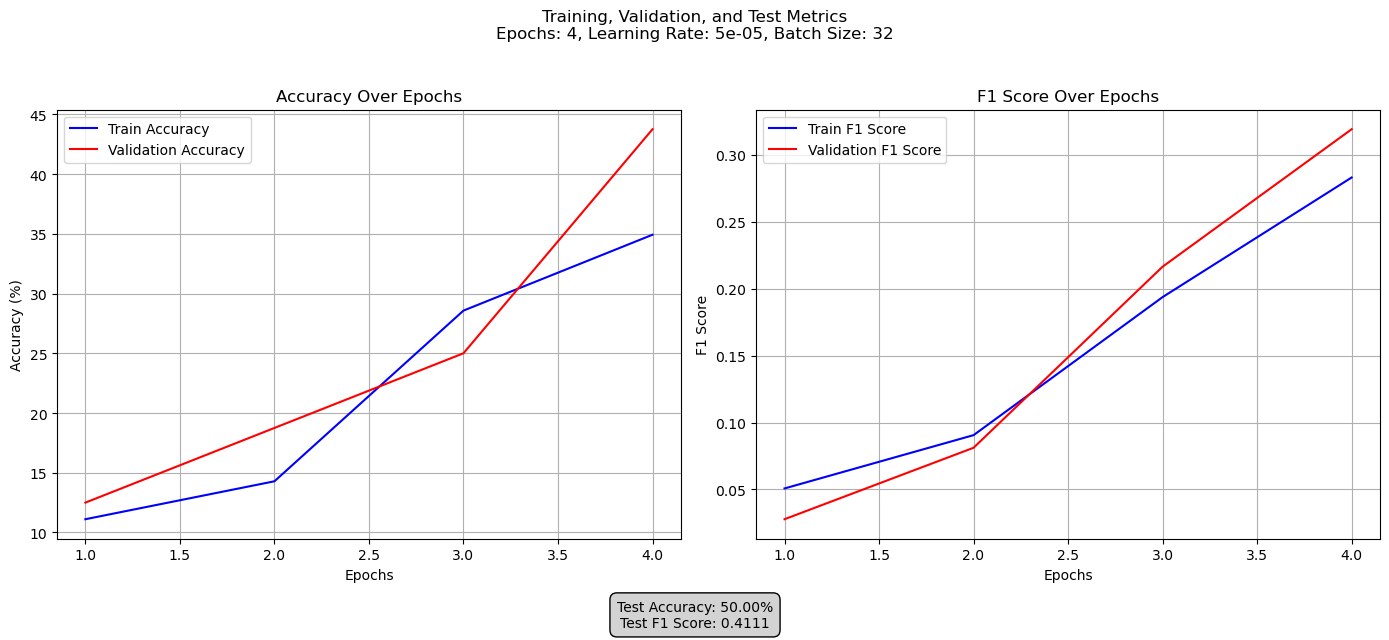

Training with params: {'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 6}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.427028, Accuracy: 11.111111%, F1 Score: 0.084311
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.191407, Accuracy: 17.460317%, F1 Score: 0.054102
Validation Accuracy: 12.500000%, Validation F1 Score: 0.031250


Training Epoch 3/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.107873, Accuracy: 19.047619%, F1 Score: 0.072740
Validation Accuracy: 12.500000%, Validation F1 Score: 0.033333


Training Epoch 4/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.027781, Accuracy: 26.984127%, F1 Score: 0.199801
Validation Accuracy: 18.750000%, Validation F1 Score: 0.125000


Training Epoch 5/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 1.902665, Accuracy: 30.158730%, F1 Score: 0.258725
Validation Accuracy: 37.500000%, Validation F1 Score: 0.261111


Training Epoch 6/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 1.741477, Accuracy: 49.206349%, F1 Score: 0.373797
Validation Accuracy: 43.750000%, Validation F1 Score: 0.354464


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

F1 Score (Weighted): 0.3300
Accuracy: 45.00%


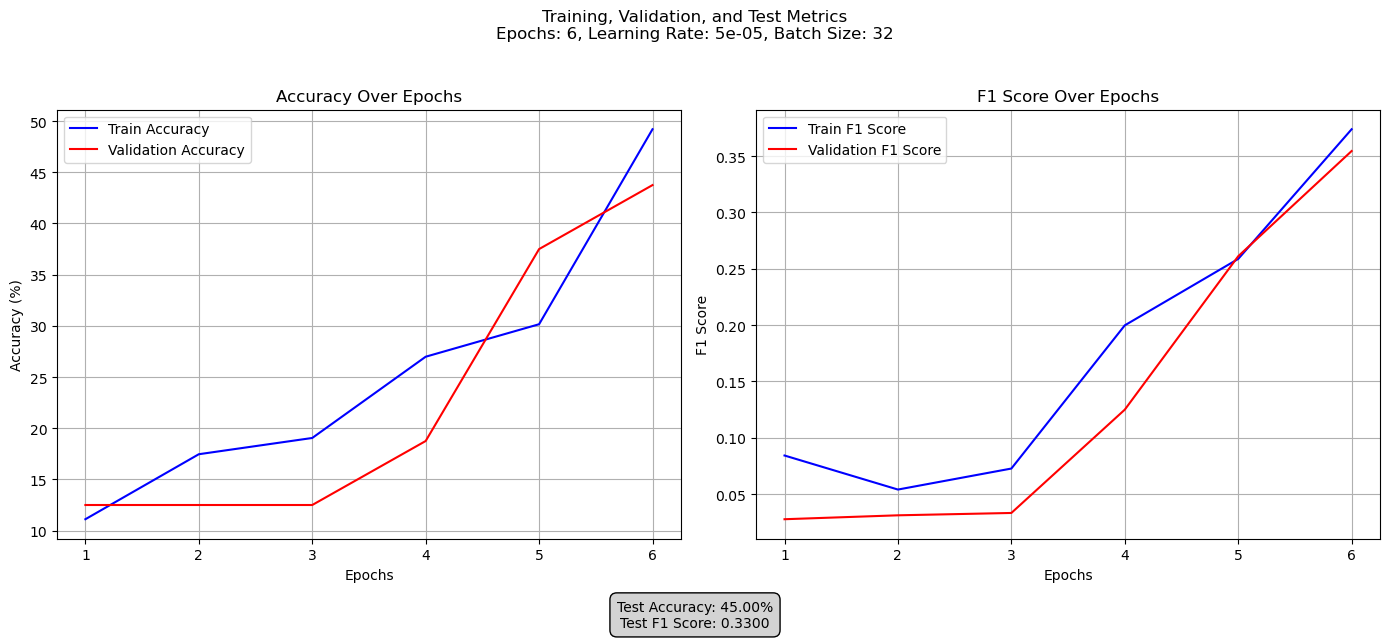

Training with params: {'learning_rate': 3e-05, 'batch_size': 16, 'num_epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.144713, Accuracy: 17.460317%, F1 Score: 0.118214
Validation Accuracy: 12.500000%, Validation F1 Score: 0.033333


Training Epoch 2/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.095263, Accuracy: 19.047619%, F1 Score: 0.122935
Validation Accuracy: 18.750000%, Validation F1 Score: 0.123162


Training Epoch 3/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 1.991175, Accuracy: 34.920635%, F1 Score: 0.300126
Validation Accuracy: 31.250000%, Validation F1 Score: 0.215278


Training Epoch 4/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 1.925522, Accuracy: 36.507937%, F1 Score: 0.298045
Validation Accuracy: 43.750000%, Validation F1 Score: 0.336458


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

F1 Score (Weighted): 0.2776
Accuracy: 35.00%


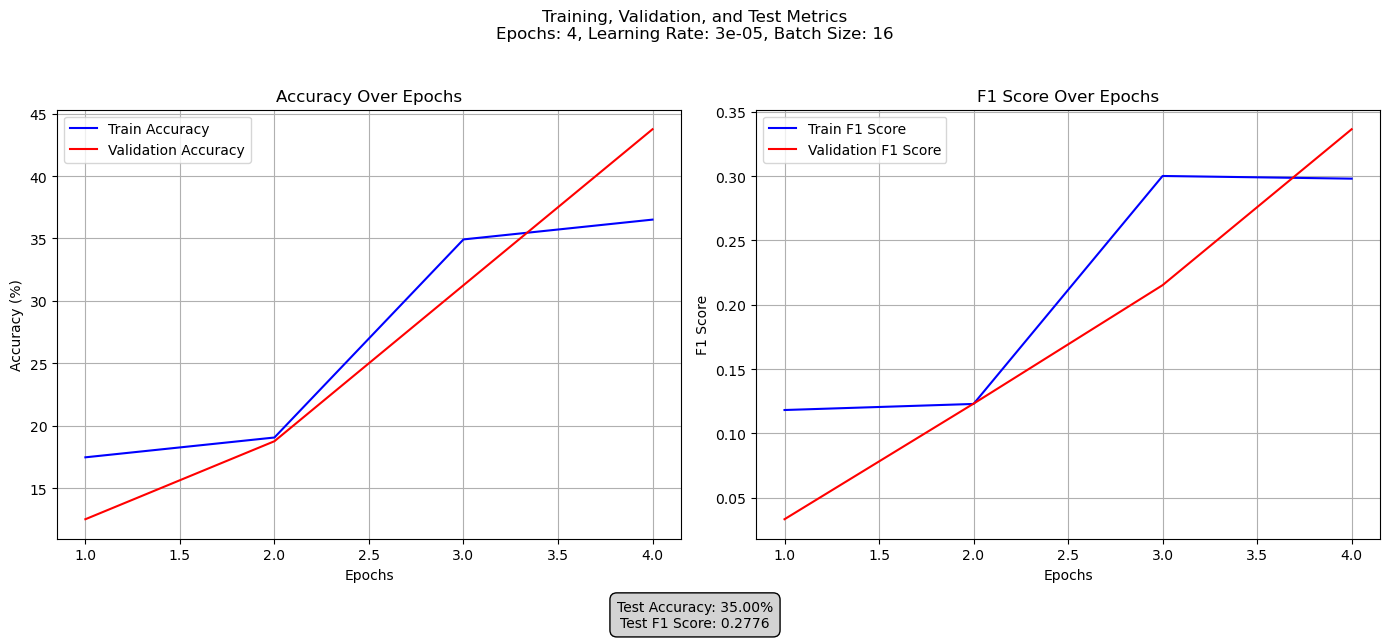

Training with params: {'learning_rate': 3e-05, 'batch_size': 16, 'num_epochs': 6}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.208720, Accuracy: 9.523810%, F1 Score: 0.093102
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 2/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.092889, Accuracy: 20.634921%, F1 Score: 0.164072
Validation Accuracy: 12.500000%, Validation F1 Score: 0.027778


Training Epoch 3/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.024444, Accuracy: 25.396825%, F1 Score: 0.183872
Validation Accuracy: 25.000000%, Validation F1 Score: 0.142857


Training Epoch 4/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 1.896544, Accuracy: 31.746032%, F1 Score: 0.238522
Validation Accuracy: 31.250000%, Validation F1 Score: 0.237500


Training Epoch 5/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 1.800671, Accuracy: 39.682540%, F1 Score: 0.328729
Validation Accuracy: 37.500000%, Validation F1 Score: 0.237500


Training Epoch 6/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 1.691851, Accuracy: 47.619048%, F1 Score: 0.409370
Validation Accuracy: 37.500000%, Validation F1 Score: 0.255357


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

F1 Score (Weighted): 0.2767
Accuracy: 35.00%


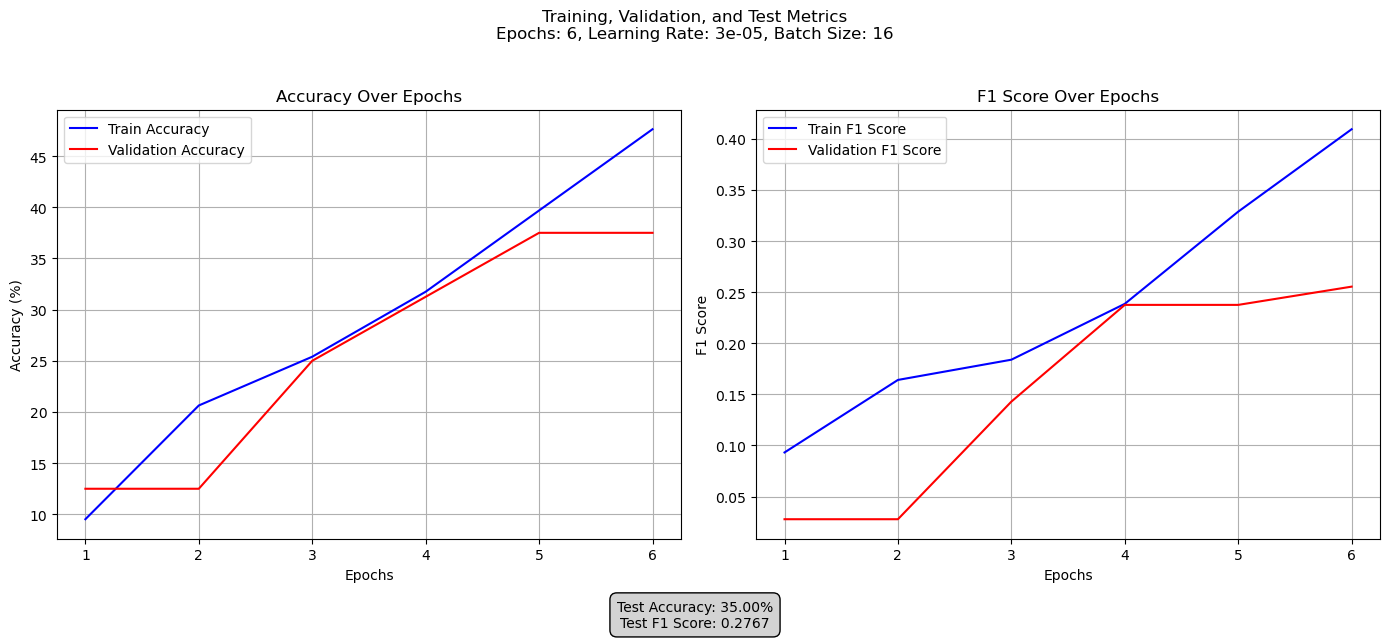

Training with params: {'learning_rate': 3e-05, 'batch_size': 32, 'num_epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 1/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.208575, Accuracy: 12.698413%, F1 Score: 0.082279
Validation Accuracy: 25.000000%, Validation F1 Score: 0.178571


Training Epoch 2/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 2/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.075109, Accuracy: 26.984127%, F1 Score: 0.204824
Validation Accuracy: 37.500000%, Validation F1 Score: 0.220982


Training Epoch 3/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 3/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.060273, Accuracy: 30.158730%, F1 Score: 0.193283
Validation Accuracy: 31.250000%, Validation F1 Score: 0.187500


Training Epoch 4/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 4/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.000233, Accuracy: 28.571429%, F1 Score: 0.203893
Validation Accuracy: 31.250000%, Validation F1 Score: 0.196023


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

F1 Score (Weighted): 0.2317
Accuracy: 35.00%


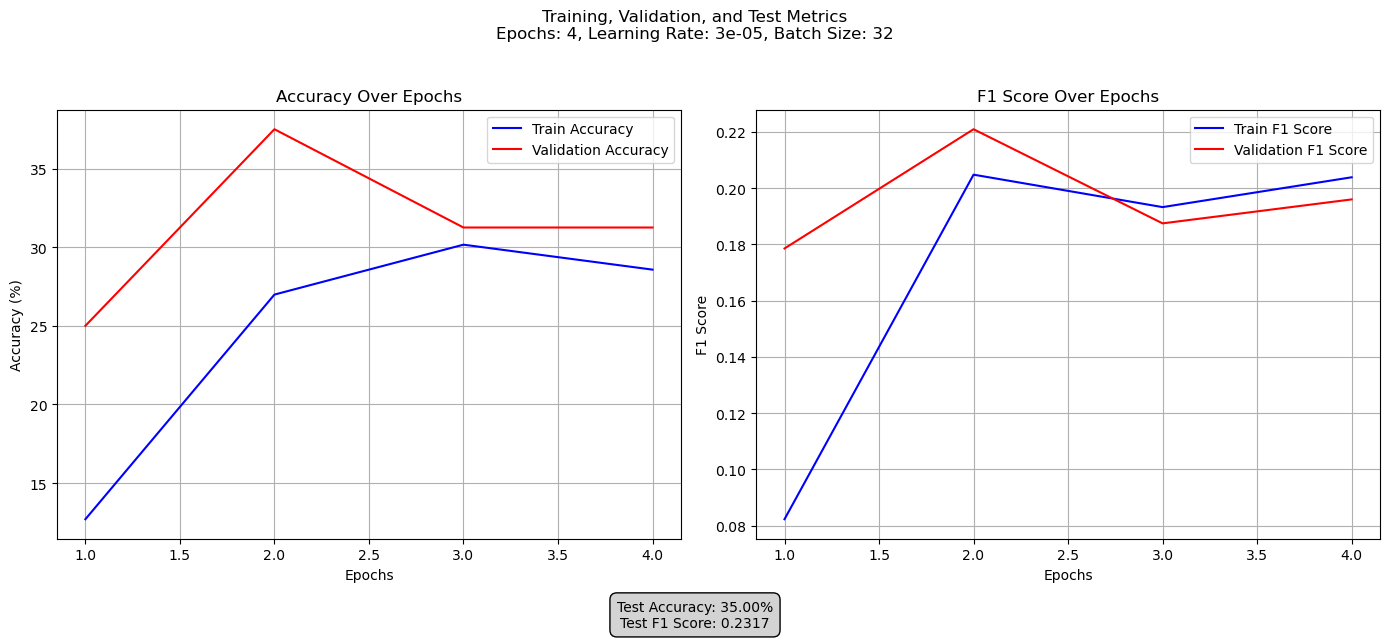

Training with params: {'learning_rate': 3e-05, 'batch_size': 32, 'num_epochs': 6}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.185824, Accuracy: 17.460317%, F1 Score: 0.111077
Validation Accuracy: 31.250000%, Validation F1 Score: 0.177273


Training Epoch 2/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.065360, Accuracy: 30.158730%, F1 Score: 0.245748
Validation Accuracy: 31.250000%, Validation F1 Score: 0.241667


Training Epoch 3/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.072230, Accuracy: 28.571429%, F1 Score: 0.274567
Validation Accuracy: 31.250000%, Validation F1 Score: 0.260417


Training Epoch 4/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.004559, Accuracy: 39.682540%, F1 Score: 0.381773
Validation Accuracy: 37.500000%, Validation F1 Score: 0.300000


Training Epoch 5/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 1.911010, Accuracy: 44.444444%, F1 Score: 0.372038
Validation Accuracy: 43.750000%, Validation F1 Score: 0.323214


Training Epoch 6/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 1.859837, Accuracy: 44.444444%, F1 Score: 0.374830
Validation Accuracy: 43.750000%, Validation F1 Score: 0.290179


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

F1 Score (Weighted): 0.3800
Accuracy: 50.00%


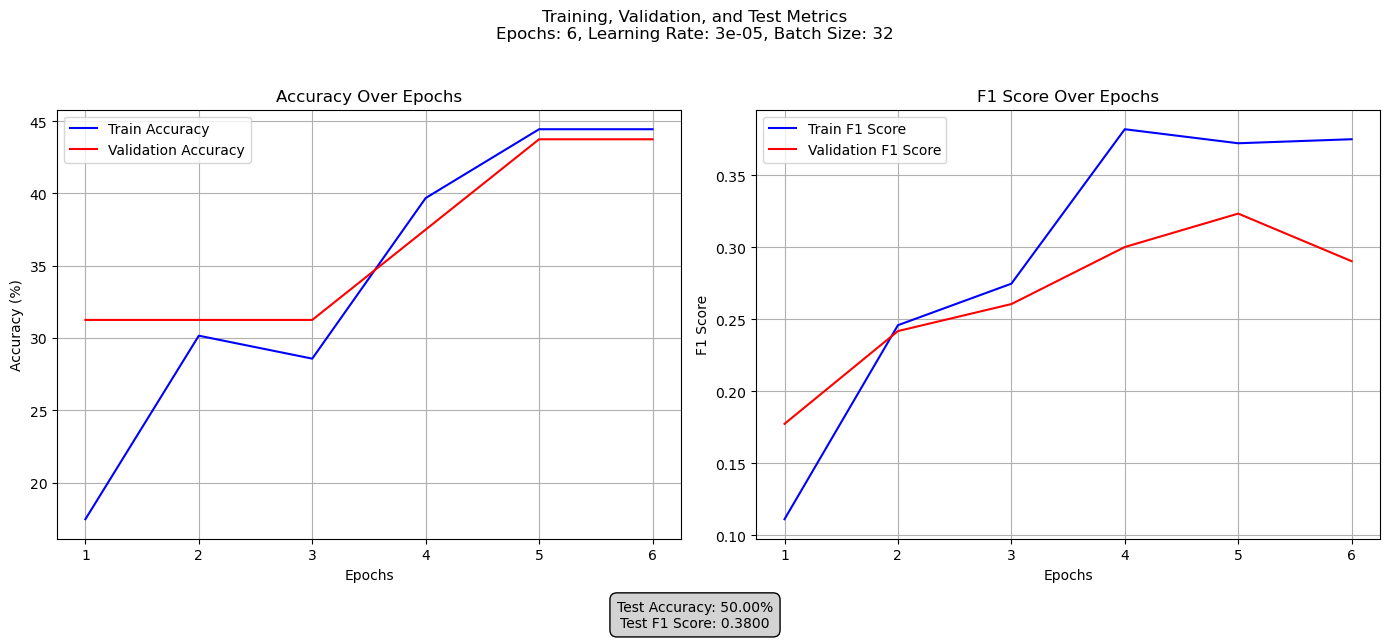

Training with params: {'learning_rate': 1e-05, 'batch_size': 16, 'num_epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.270610, Accuracy: 12.698413%, F1 Score: 0.046756
Validation Accuracy: 12.500000%, Validation F1 Score: 0.029412


Training Epoch 2/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.169104, Accuracy: 14.285714%, F1 Score: 0.091125
Validation Accuracy: 6.250000%, Validation F1 Score: 0.017857


Training Epoch 3/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.123430, Accuracy: 15.873016%, F1 Score: 0.110871
Validation Accuracy: 12.500000%, Validation F1 Score: 0.031250


Training Epoch 4/4:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.045637, Accuracy: 20.634921%, F1 Score: 0.137811
Validation Accuracy: 12.500000%, Validation F1 Score: 0.082589


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

F1 Score (Weighted): 0.0831
Accuracy: 15.00%


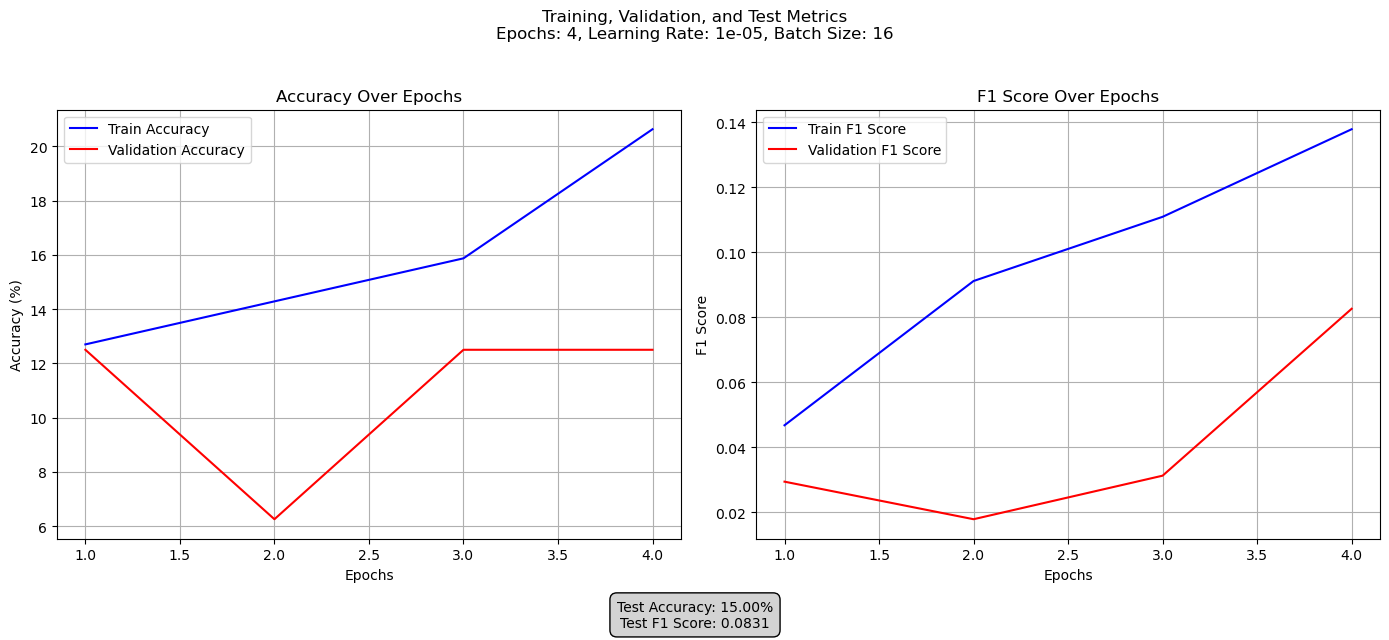

Training with params: {'learning_rate': 1e-05, 'batch_size': 16, 'num_epochs': 6}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.183616, Accuracy: 14.285714%, F1 Score: 0.127678
Validation Accuracy: 31.250000%, Validation F1 Score: 0.200000


Training Epoch 2/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.098584, Accuracy: 20.634921%, F1 Score: 0.159901
Validation Accuracy: 18.750000%, Validation F1 Score: 0.062500


Training Epoch 3/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.030230, Accuracy: 31.746032%, F1 Score: 0.269549
Validation Accuracy: 37.500000%, Validation F1 Score: 0.282143


Training Epoch 4/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 1.965578, Accuracy: 36.507937%, F1 Score: 0.288236
Validation Accuracy: 31.250000%, Validation F1 Score: 0.235714


Training Epoch 5/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 1.902129, Accuracy: 39.682540%, F1 Score: 0.334427
Validation Accuracy: 31.250000%, Validation F1 Score: 0.235714


Training Epoch 6/6:   0%|          | 0/4 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 1.837024, Accuracy: 53.968254%, F1 Score: 0.444150
Validation Accuracy: 37.500000%, Validation F1 Score: 0.327381


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

F1 Score (Weighted): 0.3095
Accuracy: 40.00%


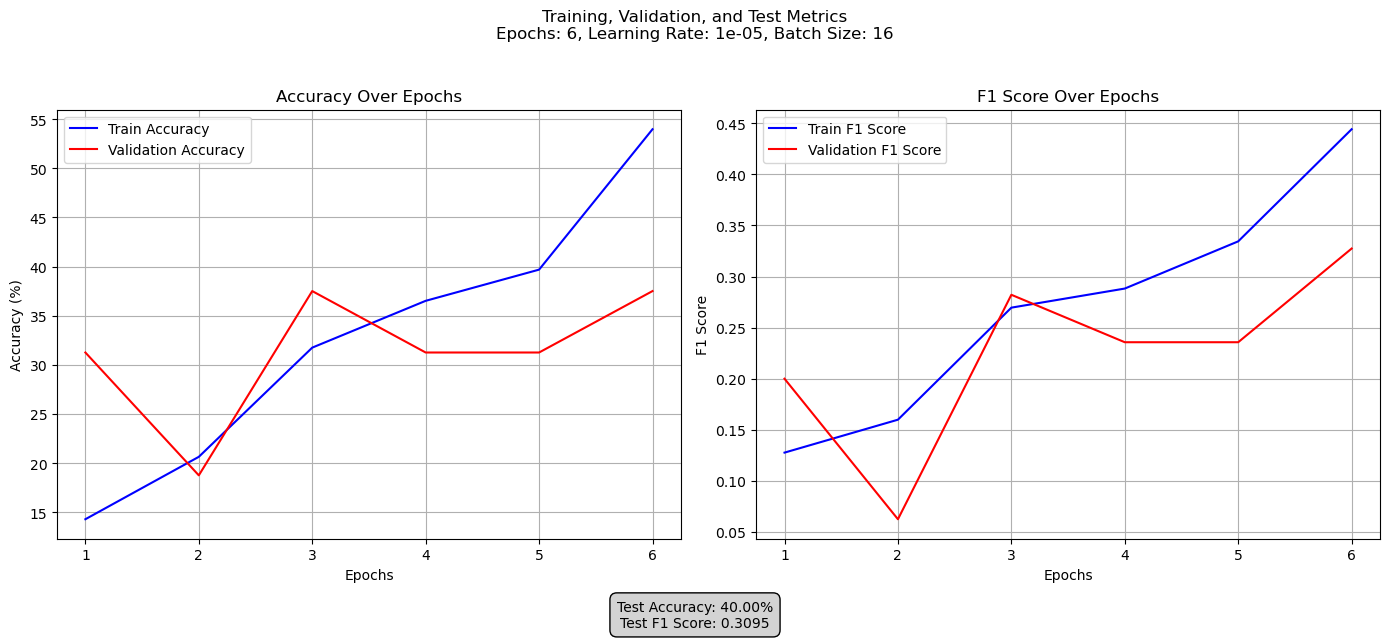

Training with params: {'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 1/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.248778, Accuracy: 14.285714%, F1 Score: 0.121860
Validation Accuracy: 18.750000%, Validation F1 Score: 0.164583


Training Epoch 2/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 2/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.148584, Accuracy: 19.047619%, F1 Score: 0.185360
Validation Accuracy: 18.750000%, Validation F1 Score: 0.204861


Training Epoch 3/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 3/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.105868, Accuracy: 22.222222%, F1 Score: 0.206070
Validation Accuracy: 37.500000%, Validation F1 Score: 0.315476


Training Epoch 4/4:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 4/4:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.050507, Accuracy: 23.809524%, F1 Score: 0.229077
Validation Accuracy: 31.250000%, Validation F1 Score: 0.244643


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

F1 Score (Weighted): 0.2709
Accuracy: 30.00%


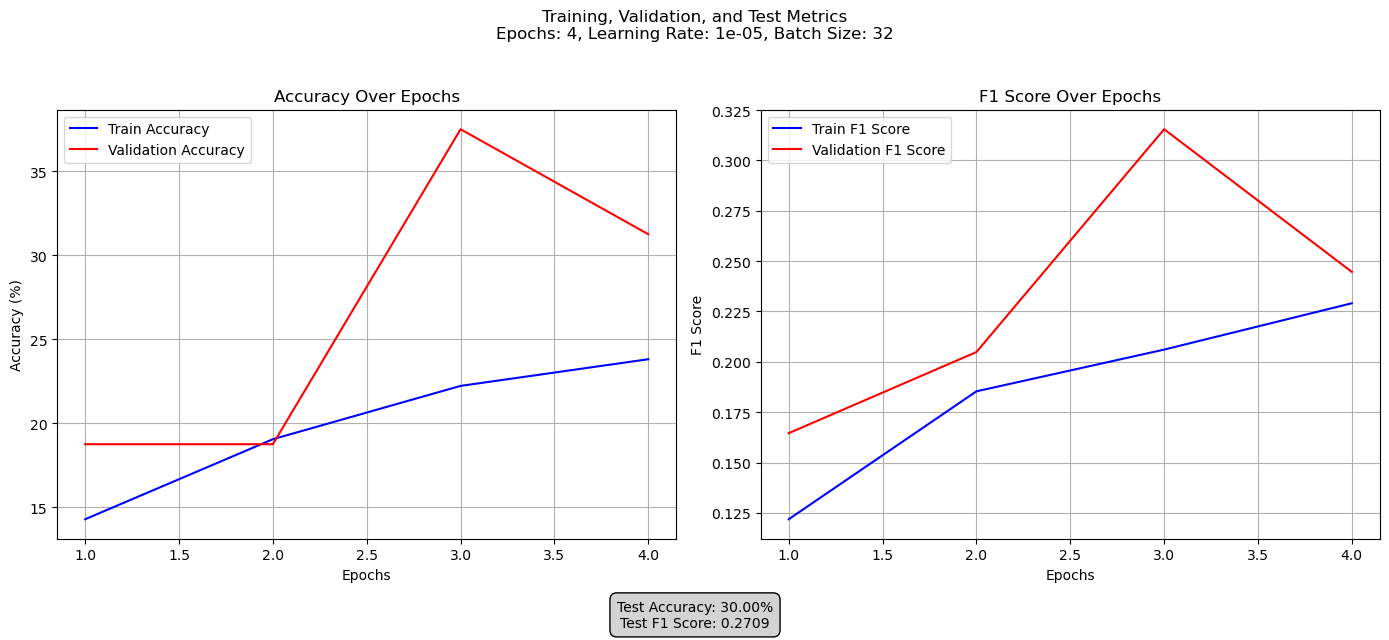

Training with params: {'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 6}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tamar\anaconda3\envs\llm_env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 1/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 2.234922, Accuracy: 9.523810%, F1 Score: 0.039828
Validation Accuracy: 25.000000%, Validation F1 Score: 0.116667


Training Epoch 2/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 2/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2, Loss: 2.198267, Accuracy: 9.523810%, F1 Score: 0.067970
Validation Accuracy: 18.750000%, Validation F1 Score: 0.062500


Training Epoch 3/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 3/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3, Loss: 2.123264, Accuracy: 20.634921%, F1 Score: 0.165655
Validation Accuracy: 25.000000%, Validation F1 Score: 0.128676


Training Epoch 4/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 4/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4, Loss: 2.088394, Accuracy: 20.634921%, F1 Score: 0.167147
Validation Accuracy: 31.250000%, Validation F1 Score: 0.158333


Training Epoch 5/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 5/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, Loss: 2.038558, Accuracy: 28.571429%, F1 Score: 0.239761
Validation Accuracy: 18.750000%, Validation F1 Score: 0.100962


Training Epoch 6/6:   0%|          | 0/2 [00:00<?, ?it/s]

Validating Epoch 6/6:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6, Loss: 2.046603, Accuracy: 22.222222%, F1 Score: 0.161172
Validation Accuracy: 12.500000%, Validation F1 Score: 0.033333


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

F1 Score (Weighted): 0.1835
Accuracy: 25.00%


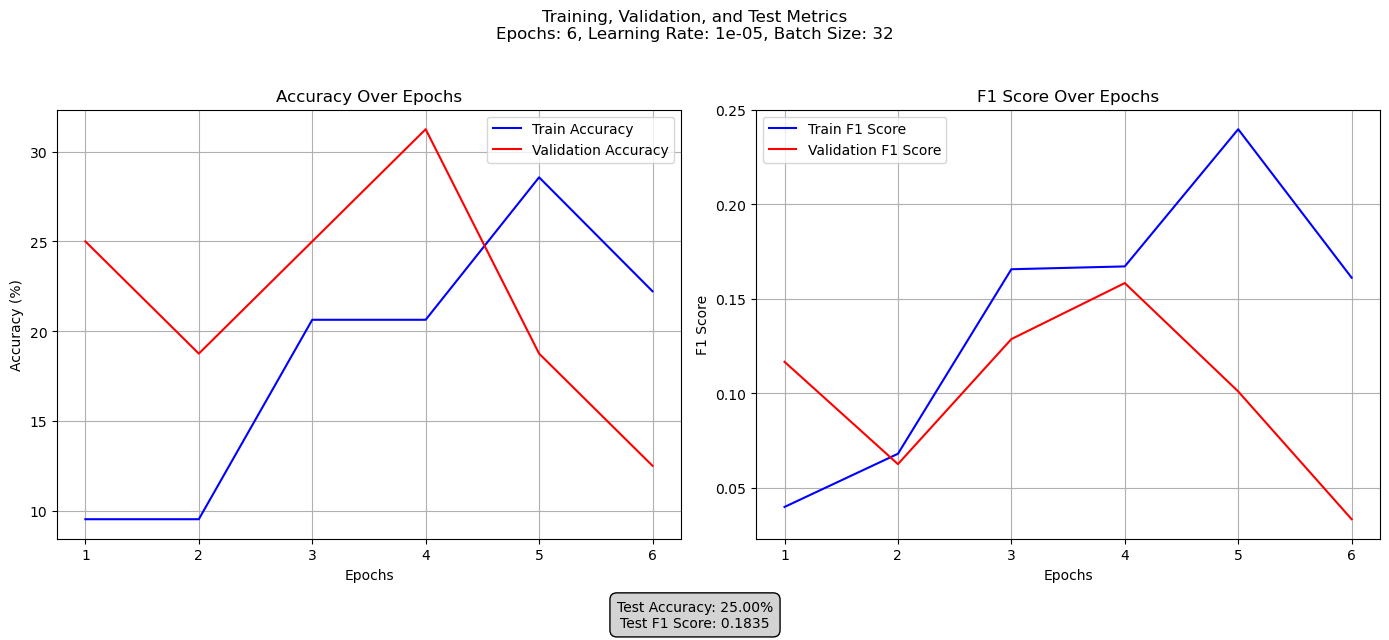

Best F1 Score: 0.4625 with parameters: {'learning_rate': 5e-05, 'batch_size': 16, 'num_epochs': 6}


In [59]:
def grid_search(param_grid):
    best_f1 = 0
    best_params = {}
    
    grid_combinations = list(product(*param_grid.values()))
    
    train_dataset = create_dataset(train_df, tokenizer, label_mapping)
    val_dataset = create_dataset(val_df, tokenizer, label_mapping)
    test_dataset = create_dataset(test_df, tokenizer, label_mapping)
    
    
    for params in grid_combinations:
        current_params = dict(zip(param_grid.keys(), params))
        
        print(f"Training with params: {current_params}")
        
        learning_rate = current_params['learning_rate']
        batch_size = current_params['batch_size']
        num_epochs = current_params['num_epochs']
        
        model = CustomBertModel(num_labels=len(filtered_labels_at_least_5_list))
        optimizer = AdamW(model.parameters(), lr=learning_rate)
        model.to(device)

        train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
        val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
        test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

        f1_train, f1_val, acc_train, acc_val = train_with_validation(model, train_loader, val_loader, optimizer, device, num_epochs)

        predictions, true_labels = test(model, test_loader, device)
        
        f1_test = f1_score(true_labels, predictions, average='weighted')
        acc_test = accuracy_score(true_labels, predictions) * 100

        plot(acc_train, acc_val, acc_test, f1_train, f1_val, f1_test, current_params)
        
        if f1_test > best_f1:
            best_f1 = f1_test
            best_params = current_params
    
    print(f"Best F1 Score: {best_f1:.4f} with parameters: {best_params}")
    return best_params
    # return acc_train, acc_val, acc_test, f1_train, f1_val, f1_test, best_params

params = grid_search(param_grid)
# acc_train, acc_val, acc_test, f1_train, f1_val, f1_test, params = grid_search(param_grid)
